In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
pd.set_option('display.max_columns',False)
sns.set(rc={'figure.figsize':(20.7,8.27)})
sns.set_style("whitegrid")
sns.color_palette("dark")
plt.style.use("fivethirtyeight")

In [2]:
df = pd.read_csv('../data/data.csv')
df = df.drop(['Unnamed: 0','Unnamed: 0.1'], axis = 1)
df = df.drop_duplicates(subset = ['deskripsi'])

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 25525 entries, 0 to 26372
Data columns (total 15 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   kamar_mandi    25525 non-null  object 
 1   kamar          25525 non-null  object 
 2   lb             24790 non-null  float64
 3   lt             21072 non-null  float64
 4   tipe_property  25525 non-null  object 
 5   price          25512 non-null  float64
 6   sertifikat     25525 non-null  int64  
 7   deskripsi      25524 non-null  object 
 8   lokasi         25156 non-null  object 
 9   ada_garasi     25525 non-null  float64
 10  pool           25525 non-null  int64  
 11  taman          25525 non-null  int64  
 12  electricity    24715 non-null  float64
 13  floors_total   25341 non-null  float64
 14  gym            25525 non-null  int64  
dtypes: float64(6), int64(4), object(5)
memory usage: 3.1+ MB


Benerin tipe data

In [4]:
df = df[df['tipe_property']=='Rumah']

In [5]:
df = df.dropna(subset = ['price','lokasi'])

In [6]:
df[['pool','taman','gym','sertifikat']] = df[['pool','taman','gym','sertifikat']].astype('bool')

In [7]:
df['ada_garasi'] = df['ada_garasi'].apply(lambda x: True if x > 0 else False)

In [8]:
df['kamar'] = df['kamar'].apply(lambda x:0 if x == '>10' else x)
df['kamar_mandi'] = df['kamar_mandi'].apply(lambda x:0 if x == '>10' else x)
df[['kamar','kamar_mandi']] = df[['kamar','kamar_mandi']].astype('float')
df[['kamar','kamar_mandi']] = df[['kamar','kamar_mandi']].astype('int')

In [9]:
df = df.reset_index()

In [10]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18230 entries, 0 to 18229
Data columns (total 16 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   index          18230 non-null  int64  
 1   kamar_mandi    18230 non-null  int64  
 2   kamar          18230 non-null  int64  
 3   lb             17972 non-null  float64
 4   lt             17830 non-null  float64
 5   tipe_property  18230 non-null  object 
 6   price          18230 non-null  float64
 7   sertifikat     18230 non-null  bool   
 8   deskripsi      18230 non-null  object 
 9   lokasi         18230 non-null  object 
 10  ada_garasi     18230 non-null  bool   
 11  pool           18230 non-null  bool   
 12  taman          18230 non-null  bool   
 13  electricity    17686 non-null  float64
 14  floors_total   18076 non-null  float64
 15  gym            18230 non-null  bool   
dtypes: bool(5), float64(5), int64(3), object(3)
memory usage: 1.6+ MB


In [11]:
df['floors_total'].describe()

count    18076.000000
mean         3.375636
std         60.031857
min         -1.000000
25%          2.000000
50%          2.000000
75%          2.000000
max       3500.000000
Name: floors_total, dtype: float64

In [12]:
import re

In [13]:
def listrik(df):    
    df['electricity_desc'] = np.zeros(len(df))
    for i in range(len(df)):
        text = str(df['deskripsi'].iloc[i]).lower().replace('.','').replace(',','')
        try:
            cari = re.search('listrik',text)
            S = cari.span()
            txt = text[S[1]:S[1]+15]
            clean = re.findall(r'[^\D]+',txt)
            clean = [int(i) for i in clean]
            if re.search(r'x',txt):
                clean = clean[0]*clean[1]
            elif (len(clean)>=2) &( (len(str(clean[1]))<=2) | (len(str(clean[0]))<=2)):
                clean = clean[np.argmax(clean)]
            else:
                clean = sum(clean)
        except:
            try:
                cari = re.search('watt',text)
                S = cari.span()
                txt = text[S[1]-10:S[1]]
                clean = re.findall(r'[^\D]+',txt)
                if re.search(r'x',txt):
                    clean = clean[0]*clean[1]
                elif  (len(clean)>=2) &( (len(str(clean[1]))<=2) | (len(str(clean[0]))<=2)):
                    clean = clean[np.argmax(clean)]
                else:
                    clean = sum(clean)
            except:
                try:
                    cari = re.search('va ',text)
                    S = cari.span()
                    txt = text[S[1]-8:S[1]]
                    clean = re.findall(r'[^\D]+',txt)
                    if re.search(r'x',txt):
                        clean = clean[0]*clean[1]
                    elif (len(clean)>=2) &( (len(str(clean[1]))<=2) | (len(str(clean[0]))<=2)):
                        clean = clean[np.argmax(clean)]
                    else:
                        clean = sum(clean)
                except:
                    clean = 0
        df['electricity_desc'].iloc[i] = clean
    return df

In [14]:
df = listrik(df)

/Users/rhzphlv/opt/anaconda3/lib/python3.8/site-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)


In [15]:
df['electricity_desc'] = df['electricity_desc'].astype('int')

In [16]:
df['listrik'] = np.zeros(len(df))
for i in range(len(df)):
    if df['electricity'].iloc[i] != df['electricity_desc'].iloc[i]:
        if (df['electricity_desc'].iloc[i] % 100 == 0) & (df['electricity_desc'].iloc[i] != 0):
            df['listrik'].iloc[i] = df['electricity_desc'].iloc[i]
        else :
            df['listrik'].iloc[i] = df['electricity'].iloc[i]

<AxesSubplot:ylabel='Frequency'>

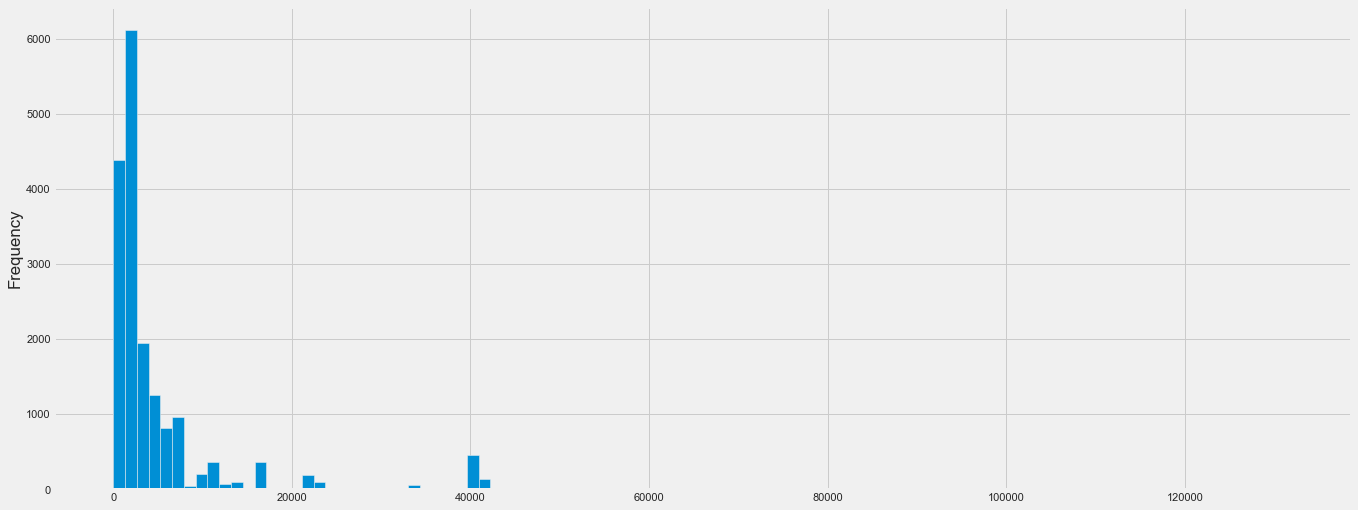

In [17]:
df['listrik'].plot.hist(bins = 100)

In [18]:
df = df[df['listrik']>10]

In [19]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 15083 entries, 34 to 18228
Data columns (total 18 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   index             15083 non-null  int64  
 1   kamar_mandi       15083 non-null  int64  
 2   kamar             15083 non-null  int64  
 3   lb                14839 non-null  float64
 4   lt                14699 non-null  float64
 5   tipe_property     15083 non-null  object 
 6   price             15083 non-null  float64
 7   sertifikat        15083 non-null  bool   
 8   deskripsi         15083 non-null  object 
 9   lokasi            15083 non-null  object 
 10  ada_garasi        15083 non-null  bool   
 11  pool              15083 non-null  bool   
 12  taman             15083 non-null  bool   
 13  electricity       15070 non-null  float64
 14  floors_total      15040 non-null  float64
 15  gym               15083 non-null  bool   
 16  electricity_desc  15083 non-null  int64